## Wavelets, Filters and Data QC  

This notebook loads a VSP data set into 2 numpy arrays   
It gives examples of editing, plotting and filtering the VSP  
Common instantaneous attributes are calculated and displayed
It also give examples of 3 common seismic wavelets

In [7]:
# important geophysical imports
# I use several methods to load packages as examples

from io_vsp.segyin import readsegyio3
from io_vsp.segyout import write_segyio

from plot_vsp.seisplots import wiggle_plot, four_plots, plotcolor
from proc_vsp.geometry import importascii, geovel

# Best method is the one below, you always know where functions are 
# coming from
import proc_vsp.spec as spec_vsp
import proc_vsp.spec2d as spec2d

import proc_vsp.sigproc as sgp
import proc_vsp.utils as utilvsp
import proc_vsp.wavelets as wav

## Load the VSP SEG-Y file  
 
 - uses segyio data loading package
 - source and receiver locations are assumed to be in SEG-Y trace headers
 - user needs to supply basic geometry parameters
      - seismic replacement velocity
      - surface seismic datum elevation
      - drill floor elevation
      - source elevation  

The sample rate read from the file needs to be QC'ed!!!

In [8]:
#################### get the ZVSP SEGY filename ############################
    
#    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts\\Synthetic_data\\data\\zvsp_z_fd_mod6_12p5ft_grid_delayed.sgy')
#    filename = ('C:\\Users\\acampbell45\\Documents\\Python_Scripts\\VSP-processing\\data\\Tillard_ZVSP_raw_z_stacked.sgy')

filename = (r'C:\Users\hooge\GitHub\Geophysics\VSP_Basics\data\zvsp_z_fd_mod7a_12p5ft_grid_delayed.sgy')

################### input desired geometry parameters ######################

RepVel= 5000     # replacement velocity
SRD_ASL = 0    # SRD elevation above sea level
DF_ASL = 0    # drill floor elevation ASL
SrcElev = -10   # source elevation ASL

###################### run basic segy loading functions #################### 

file_head = 'n'         # print binary and text header to screen    
pr_thead = 'n'          # print a table of trace headers

data, numsamp, samprate, fs, theader =  readsegyio3(filename, file_head,  DF_ASL, SrcElev, SRD_ASL, pr_thead)


̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲w̲i̲t̲h̲ ̲s̲e̲g̲y̲i̲o̲ ̲S̲t̲a̲t̲s̲ ̲:

 data shape : (320, 4550)  delta t : 1000.0
 data type : float32
 trace header file shape : (320, 15)
 samples : 4550  traces : 320  fs samprate hz :  1000.0 samprate microseconds :  1000 
 numsamp from headers :  4550
 first time header value :  [11.31] 
 first lag time A value : [0] 
 first lag time B value : [11]
 source depth from header trace 1 : [10.]


## Velocity Calculations  
 - Calculate interval velocities. Shallowest velocity is calculated separately and tacked on to velocity array  
 - Generate a version which is rounded and truncated for display as text

In [9]:
############ geometry corrections and velocity calculations ################

table = 'n'     # print a time-depth-velocity listing to screen y or n    
vel_headers = geovel( theader, RepVel, table)


̲G̲e̲o̲v̲e̲l̲ ̲S̲t̲a̲t̲s̲ ̲:
 Theader shape (320, 15) Vheader shape: (320, 17)
 TVD_SRD shape : (320,)  IntVel shape : (320,)
 TVDSrc 2 vals   [ 90. 140.] 
 TVDSRD 2 vals  [100. 150.] 
 TTVert 2 vals   [11.312 17.102]


## Chose the desired trace range to process

In [10]:
###################### trim arrays by receiver  ############################

first_rcv =1
last_rcv = 200   
data_edit, theader_edit = utilvsp.depthlimit(data,vel_headers, first_rcv, last_rcv)



̲D̲e̲p̲t̲h̲l̲i̲m̲i̲t̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape :  (320, 4550)  data dtype :  float32
 headers shape : (320, 17)
 first : 0  last :  199
 headers new shape : (199, 17)
 data new shape :  (199, 4550)


## Trace normalize data file  
 Remove transmission effects and uncorrected gain effects  
 on downgoing by normalizing the downgoing amplitudes  
 - normalize by row (receiver) using Frobenius normalization. Can be changed to other norms.  
 - Be careful with axis number, determines trace normalization or time normalization



̲N̲o̲r̲m̲a̲l̲i̲z̲a̲t̲i̲o̲n̲ ̲S̲t̲a̲t̲s̲ ̲:
 norm : y


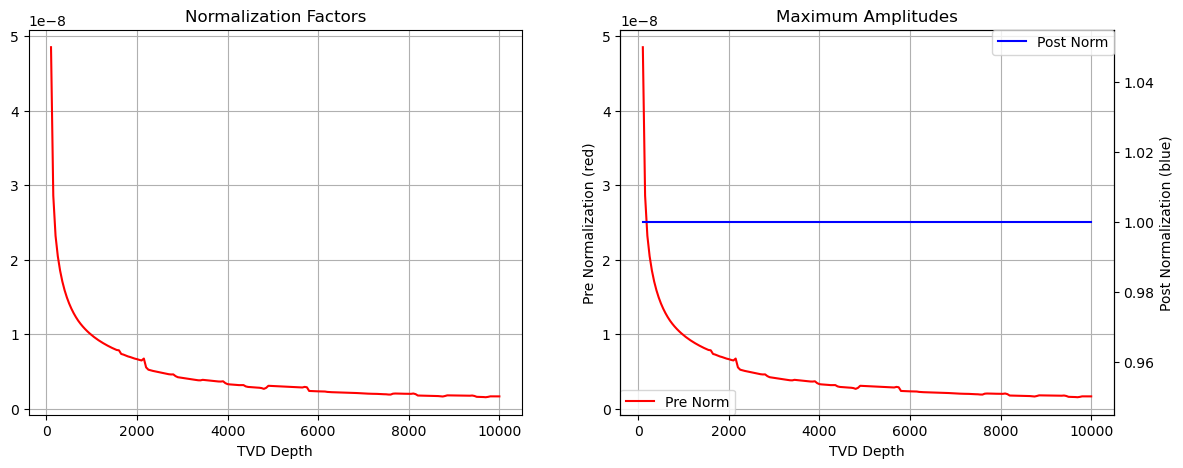

In [11]:
############  apply trace normalization if requested #######################  

Data_norm = 'y'         # normalize data, n for gather norm, y for trace nrm
DScalar = 1             # usually 1, may be removed in future    
normed_edit = sgp.normalize(data_edit, Data_norm, theader_edit, DScalar)

## Example of Applying a Band-Pass( Butterworth) Filter  
 - Make 2 simple QC plots of frequency and impulse response
 - Plot the filtered VSP

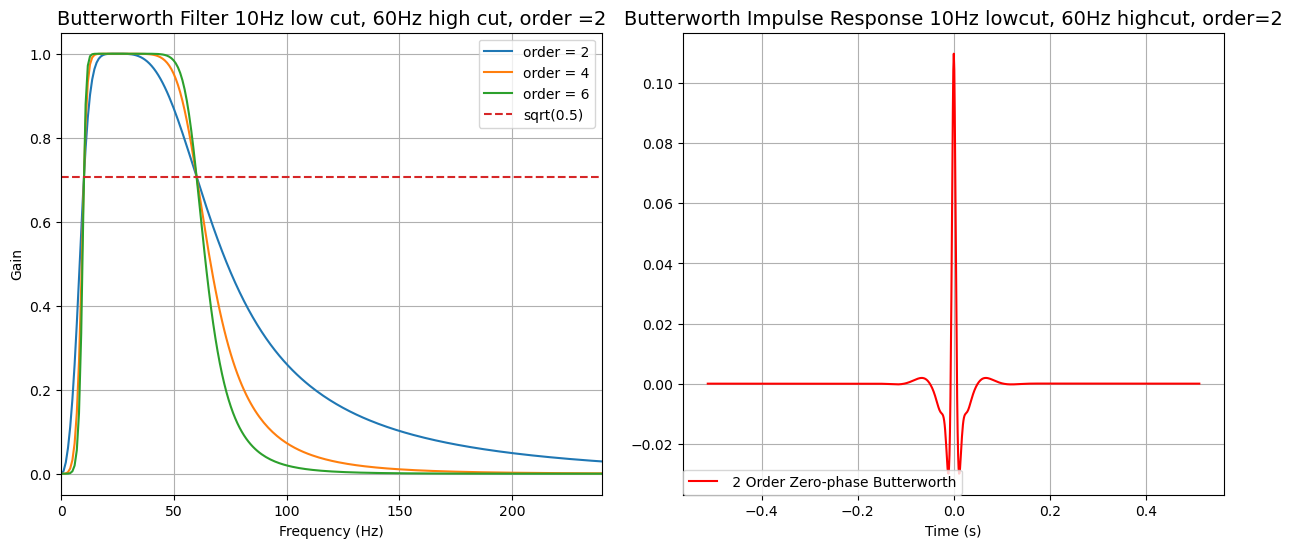

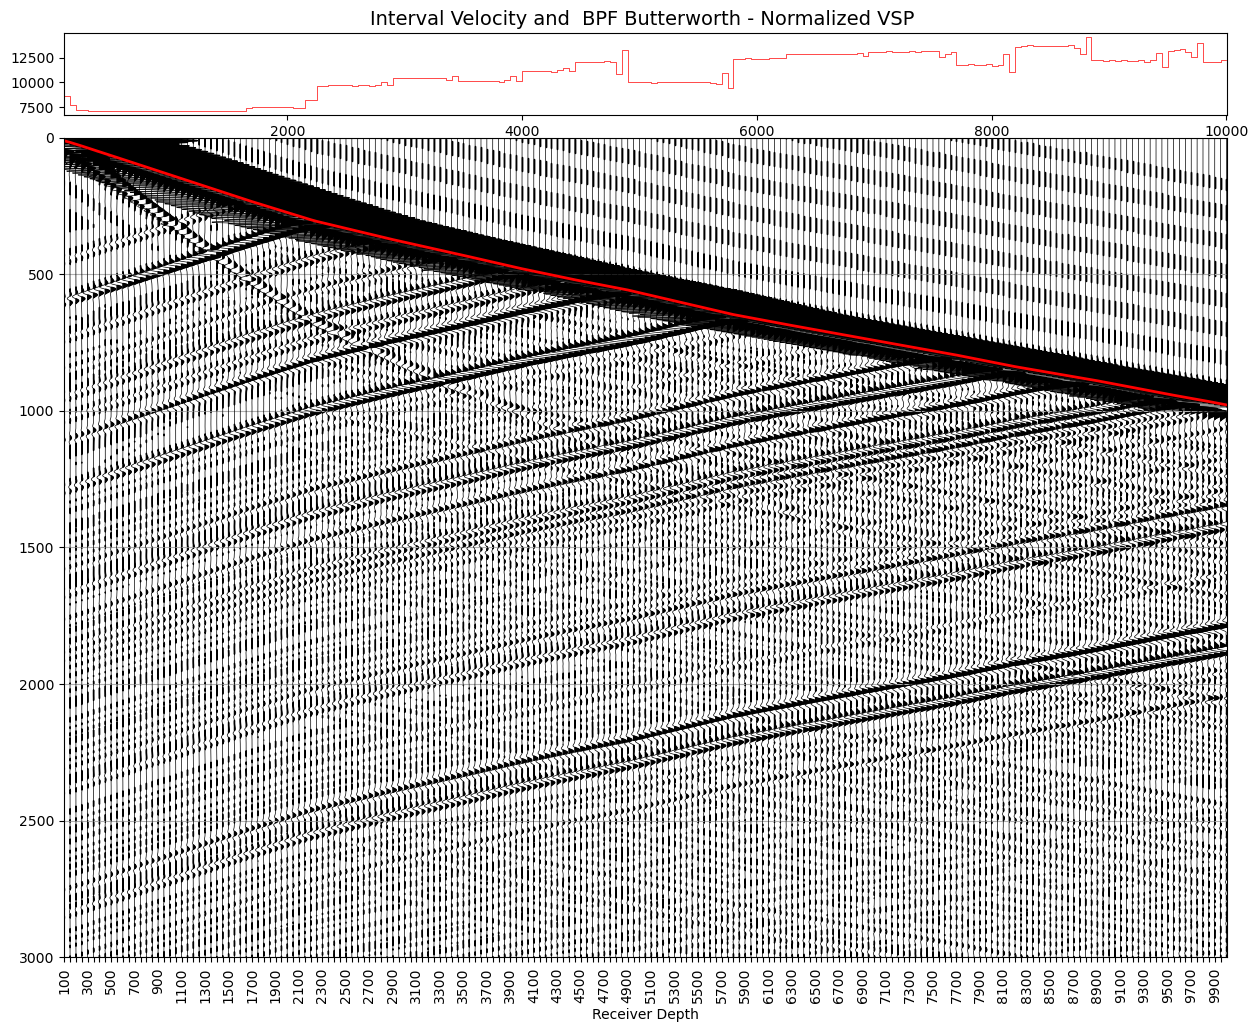

In [12]:
################### Butterworth filter testing #############################

# Sample rate and desired cutoff frequencies (in Hz).

lowcut = 10
highcut = 60
qcplot = 'y'
order  = 2     # order gets doubled by implementation of filter, be careful    
numfsamp = 1024   # for wavelet QC plot, must be even      
buttfilt = spec_vsp.bandpass_filter(normed_edit, lowcut, highcut, fs, order, 
                                    numfsamp, qcplot)
# make a wiggle plot of traces
plot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":1000, 
                "title_top":' BPF Butterworth - Normalized VSP ',
                "info_wig":'n',
                "timframe":'owt'}
wiggle_plot(theader_edit,buttfilt, **plot_params)

## A simple Bandpass Filter  
  Convolve data with a custom windowed sync filter  
  An alternative to Buttworth filter

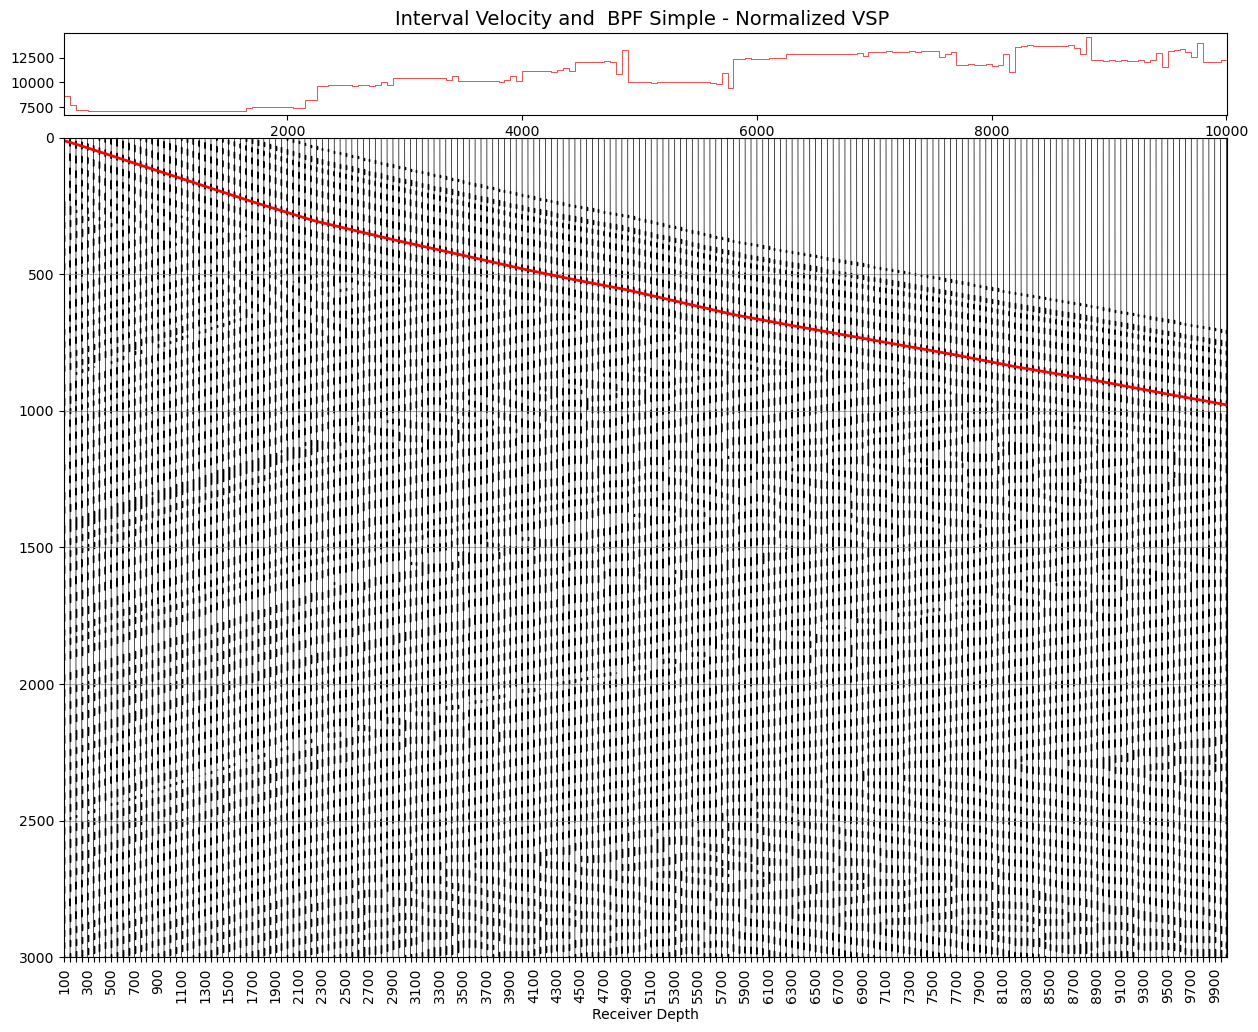

In [13]:
######################## Simple BPF testing ################################

lowcut = 20
highcut = 80
rolloff_low = 15
rolloff_high = 25

simpfilt = spec_vsp.simple_bpf(normed_edit, lowcut, highcut, rolloff_low, rolloff_high, fs)
# make a wiggle plot of traces
plot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":1000, 
                "title_top":' BPF Simple - Normalized VSP ',
                "info_wig":'n',
                "timframe":'owt'}
wiggle_plot(theader_edit, simpfilt, **plot_params)

# Frequency Analysis  - 1D  
A windowed spectrum for one trace  
Amplitude and Power are plotted

In [15]:
    ########################  FRequency ANalysis    ############################
    
    trace = 80
    time_win = 'y' # window trace prior to fft
    time_range = [0, 2000]
    freq_range = [0, 150]    
    title_fran = 'Raw Z'    
    spec_vsp.spec_1d(data_edit, time_range, freq_range, theader_edit, trace, fs, 
         time_win, title_fran)
    
    title_fran = 'BPF Raw Z'
    print( ' buttfilt type :',buttfilt.dtype)    
    spec_vsp.spec_1d(buttfilt, time_range, freq_range, theader_edit, trace, fs, 
         time_win, title_fran)



̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0


 buttfilt type : float32

̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0


# Frequency Analysis  - Frequency/Depth  
An image plot of frequency spectra for every receiver   
Amplitude and Power are plotted

In [16]:
    # 2D spectra - a spectrum per trace
    spacing = 'z' # Z for traces spread by receiver depth    
    scale = 5 # scale up image apmlitude plot
    title_fran = 'Raw Z'
    time_win = 'y' # window trace prior to fft
    time_range = [0, 3050]
    freq_range = [0, 150]    
    trace_range = [1, 200]
    db_range = [-90,0]
    spec_vsp.spec_FZ(data_edit, time_range, theader_edit, fs, spacing, 
         db_range, freq_range, trace_range, scale, title_fran, time_win)


̲F̲r̲A̲n̲ ̲i̲m̲a̲g̲e̲2̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 data shape : (198, 4550)  TTobs shape : (199,)
 trindex.min(): 1.0  trindex.max(): 199.0
fs : 1000.0


(array([[6.74935585e-09, 6.26191479e-09, 5.57201690e-09, ...,
         1.09809932e-12, 9.59879025e-13, 7.82441692e-13],
        [6.93042346e-09, 6.40051719e-09, 5.68748517e-09, ...,
         2.90928639e-12, 2.82067949e-12, 2.74227616e-12],
        [7.34152499e-09, 6.70803663e-09, 5.94181701e-09, ...,
         7.27567619e-12, 7.38118423e-12, 7.50127780e-12],
        ...,
        [1.14632644e-14, 1.03246921e-14, 1.61714427e-15, ...,
         9.51014591e-15, 4.34736919e-15, 1.10880750e-14],
        [1.16703977e-14, 1.04972668e-14, 1.19183957e-15, ...,
         8.69890733e-15, 1.77041673e-14, 1.19149505e-15],
        [1.16646465e-14, 1.03787153e-14, 8.34074655e-16, ...,
         5.42859904e-15, 1.10291960e-15, 4.42084879e-15]],
       shape=(1536, 198)),
 array([[ -16.48713277,  -17.13823624,  -18.1521308 , ...,  -92.25954684,
          -93.42804927,  -95.20333964],
        [ -16.25718387,  -16.94807793,  -17.97397376, ...,  -83.79664979,
          -84.06530448,  -84.31015555],
        [ -

## F/K Spectrum

Utilizes 2D FFT
Constant receiver spacing is assumed


̲n̲e̲x̲t̲p̲o̲w̲2̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s
 x : 4550
 nextpow2 : 13.0

̲f̲k̲t̲r̲a̲n̲_̲n̲u̲m̲p̲y̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲b̲e̲f̲o̲r̲e̲ ̲f̲f̲t
 seis.T shape : (4550, 199) 
 numsamp : 4550 
 ntrace : 199
 rcvz shape : (199,) 
 t shape : (4550,) 
 dx : 50.0 
 dt : 0.001
 nf : 8192 
 nk : 8192
 fk shape : (8192, 8192)
 freq min -500.0  freq max 499.8779296875
 k min -0.01  k max 0.00999755859375
 fk_for_plot shape : (8192, 4095)

̲f̲k̲ ̲p̲l̲o̲t̲ ̲i̲n̲f̲o̲ ̲a̲n̲d̲ ̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s
fk shape : (4095, 8192)
 df : 0.1220703125 
 stop freq index : 655 
 f shape : (8192,) 
 dk : 2.4414062499995143e-06 
 startk : 1024 
 stopk : 7168
 kvel, fvel: [0, np.float64(-0.08331298828125)] [0, np.float64(499.8779296875)]  slope : -6000.0
 xy label location: (-0.00375, np.float64(22.5))


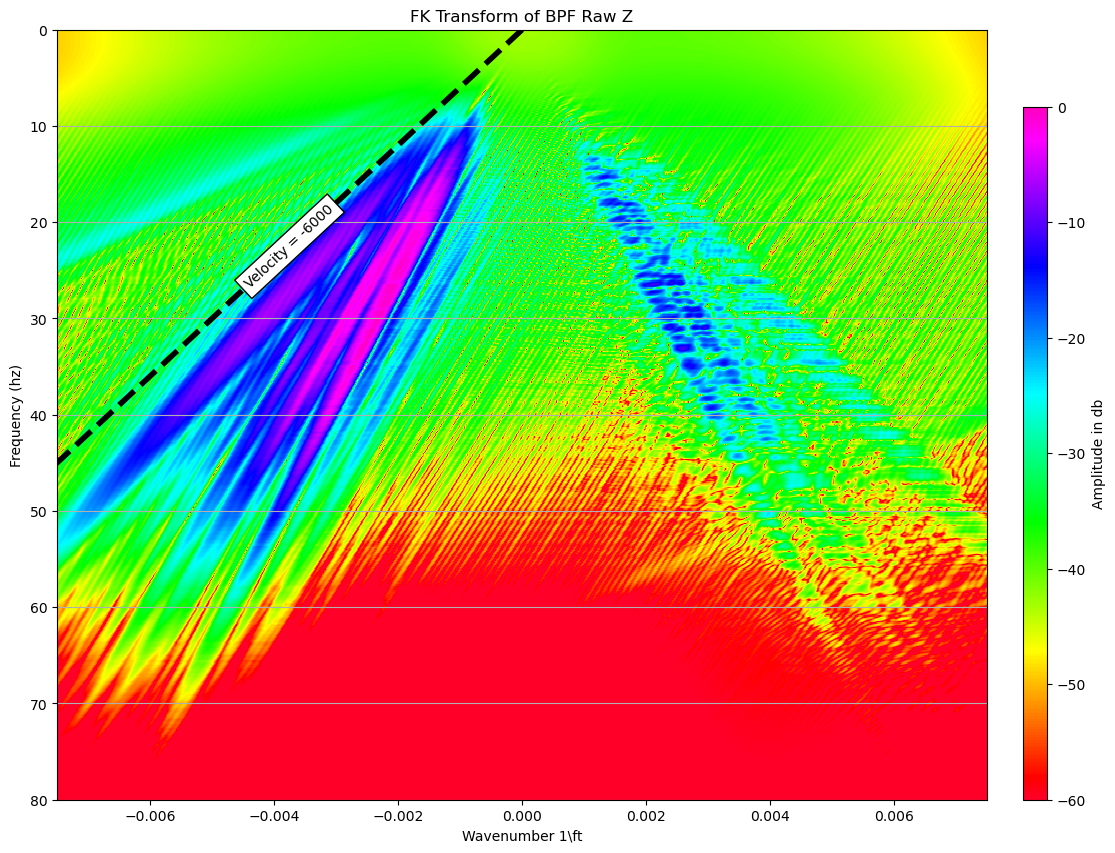

In [17]:
############################ FK analysis ####################################

ishift = 1                                      # display positive freqs.
title_fk='FK Transform of BPF Raw Z'
line_velocity=-6000    
fktrans, freqnp_unwrap, knp_unwrap, numsamp, ntrace = spec2d.fktran_numpy(buttfilt, theader_edit, fs, ishift, title_fk, line_velocity)
                

## Instantaneous Attributes  
The program uses the Hilbert transform to calculate the analytic traces.

It is hardwired to write out:
1. Instantaneous Phase (wrapped)  
2. Instantaneous Frequency  
3. Amplitude Envelope

Plotting is a separate routine, plots attributes as color images  



̲A̲t̲t̲r̲i̲b̲u̲t̲e̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs : 1000.0 
  max trace amplitude :  4.8525173e-08 
  max amplitude envelope :  5.079149e-08 
  max inst frequency :  500.0014305114746 
  max inst phase :  180.0
 inst freq shape : (199, 4549)
 inst amp shape : (199, 4550)
 freq_mid shape:  (4550,)  amp_mid shape:  (4550,)
VSPdata shape: (199, 4550) tindex shape : (199, 4550) rindex shape : (199, 4550)


c:\Users\hooge\GitHub\Geophysics\VSP_Basics\plot_vsp\seisplots.py:741: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax2.legend(loc='best')


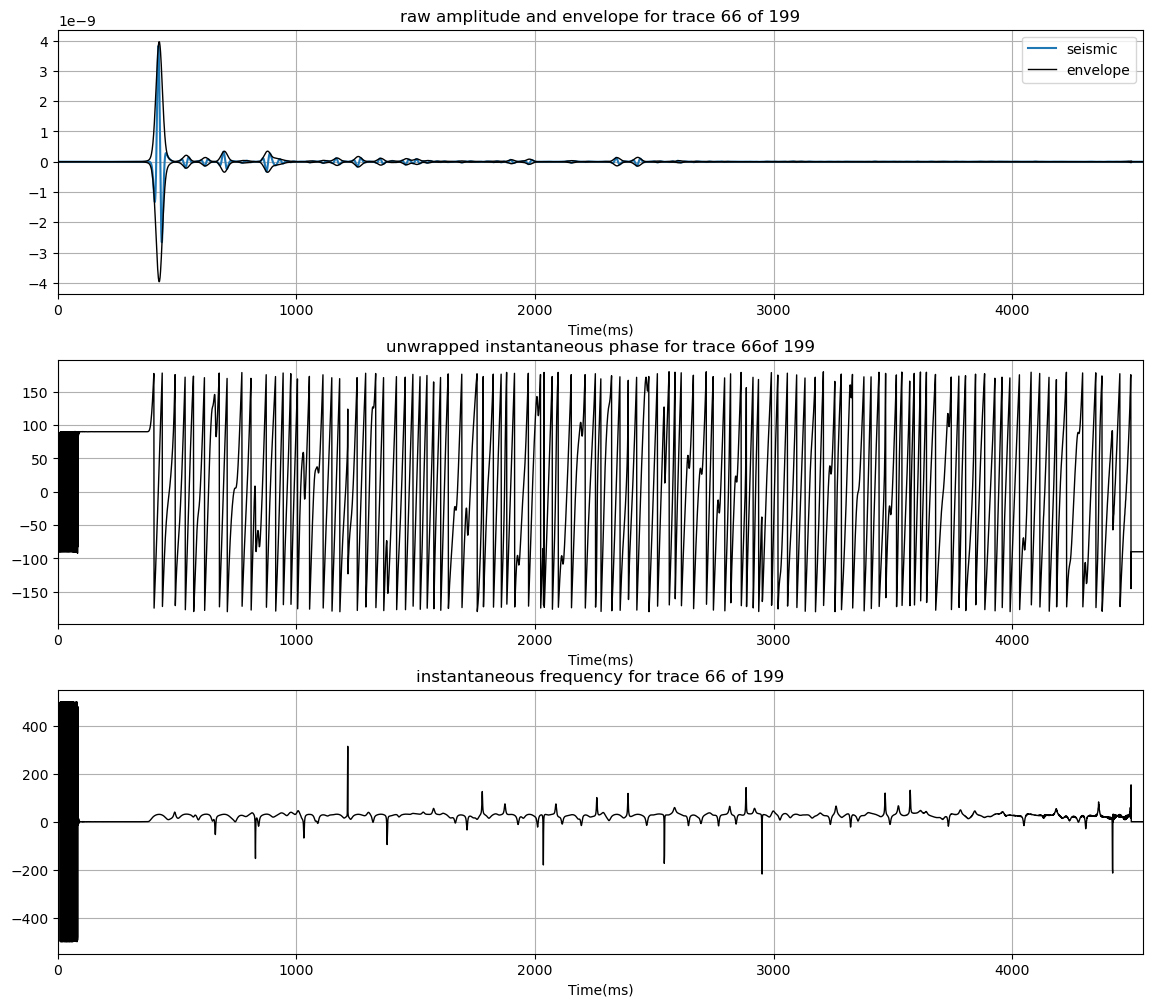

VSPdata shape: (199, 4550) tindex shape : (199, 4550) rindex shape : (199, 4550)


c:\Users\hooge\GitHub\Geophysics\VSP_Basics\plot_vsp\seisplots.py:741: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax2.legend(loc='best')


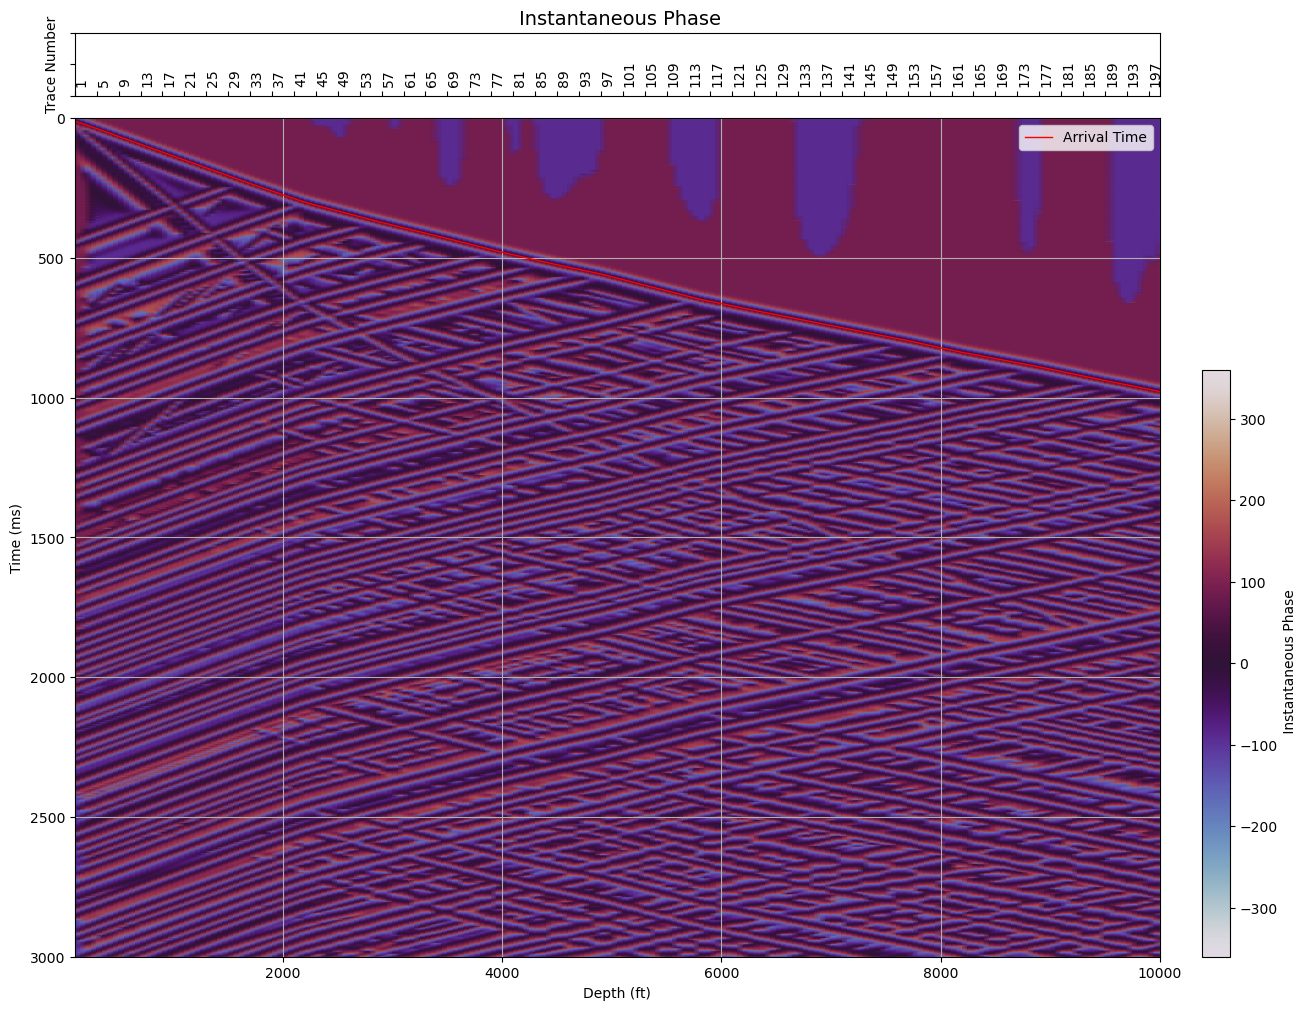

In [18]:
################# calculate instantaneous attributes ###################

data_env, data_ifreq, data_iphase = sgp.attributes(data_edit,fs)
    
colorplot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":0, 
                "show_time":'y', # show arrival time curve
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4,
                "samp_decimate":1,
                "fs":fs, 
                "norm":'n',
                "min_amp":0, "max_amp":.4e-8,
                "title_top":' Amplitude Envelope',
                "color": 'viridis',
                "png":'n'}
plotcolor(theader_edit, data_env, **colorplot_params)

colorplot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":0,
                "show_time":'y', # show arrival time curve
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4,
                "samp_decimate":1,
                "fs":fs, 
                "norm":'n',
                "min_amp":-360, "max_amp":360,
                "title_top":' Instantaneous Phase',
                "color": 'twilight',
                "png":'n'}
plotcolor(theader_edit, data_iphase, **colorplot_params)        

## Play with some wavelets  
Ricker, Ormsby and Butterworth are implemented


Ormsby Info
 duration : 1.024  dt : 0.002  f : [[ 6]
 [18]
 [45]
 [65]]
 presqueeze w shape : (512,)



Ricker Info
 duration : 1.024  dt : 0.002  f : 30



̲B̲u̲t̲t̲e̲r̲w̲o̲r̲t̲h̲ ̲W̲a̲v̲e̲l̲e̲t̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:

 fs : 1000.0  N : 1024  order : 3
 center : 513  a few values of x : 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


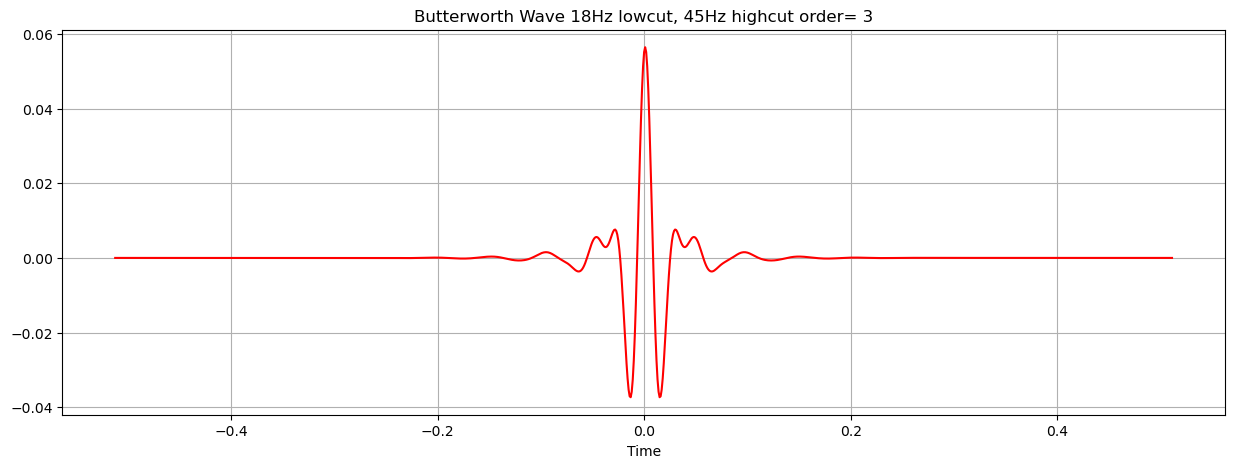

array([-1.25105873e-08, -1.57174065e-08, -1.88684072e-08, ...,
       -4.35938844e-09, -5.99480168e-10,  2.73624994e-09], shape=(1024,))

In [19]:
######################## Ormsby Wavelet   ##################################
timlength=1.024
sampint = .002
flimits = [6,18,45,65]
ormwave = wav.ormsby(timlength, sampint, flimits)

######################## Ricker Wavelet   ##################################
timlength=1.024
sampint = .002
flimits = 30
rickwave = wav.ricker(timlength, sampint, flimits)

###################### Butterworth Wavelet   ###############################
lowcut = 18
highcut = 45
order  = 3   # order gets doubled by implementation of filter, be careful    
numfsamp = 1024   # for wavelet QC plot, must be even     
wav.butterworth(lowcut, highcut, fs, numfsamp, order)